# Geography_Tools Examples
This notebook will give you a quick rundown of the methods and tools used in Geography_Tools.py. There are a good number, but most are relatively uncomplicated. To get ourselves started, we're going to need some bits of geospatial data. For the purposes of our demonstration, I'll provide a series of geospatial coordinates that follow a particular stretch of road in Redmond, Washington. Normally, however, you will probably want to use a shapefile. Fortunately, there's already plenty of documentation out on the web to figure that part out. And if there isn't, well... I'd reckon there are bigger issues afoot. 

The Raster elevation files can be downloaded from [The Washington Lidar Portal](https://lidarportal.dnr.wa.gov/#47.63636:-122.11905:13). Specifically, for this example I am using Redmond 2014's DTM (digital terrain model), which represents the tree-less and building-less topography of a landscape.

First things first, let's get the road's data prepped and ready. 

In [1]:
import pandas as pd
import sys
import os
sys.path.append('../src/')
from reRoute_Dynamics import Geography_Tools as gt

route_geodata_path = "./KC_Example_Data/Example_Route_Data/example_redmond_road.csv"
route_geodata = pd.read_csv(route_geodata_path, header=None)
route_geodata

,0,1
0,47.66690,-122.12870
1,47.66712,-122.12750
2,47.66732,-122.12583
3,47.66734,-122.11931
4,47.66731,-122.11267
5,47.66767,-122.11051
6,47.66879,-122.10836
7,47.66940,-122.10763
8,47.67063,-122.10688
9,47.67129,-122.10660


There, we have the latitudes and longitudes of some points on that route! <br> Let's also grab the path for our elevation rasters, while we're at it. 
This directory will differ depending on where you download them on your computer, so be sure to adjust your path accordingly!


In [2]:
import os
redmond_rasters_path = "./KC_Example_Data/Example_Raster_Data/Redmond_2014/dtm/"
os.listdir(redmond_rasters_path)

['redmond_2014_dtm_0.tif',
 'redmond_2014_dtm_0.tif_EPSG4326.tif',
 'redmond_2014_dtm_1.tif',
 'redmond_2014_dtm_1.tif_EPSG4326.tif',
 'redmond_2014_dtm_2.tif',
 'redmond_2014_dtm_2.tif_EPSG4326.tif',
 'redmond_2014_dtm_3.tif',
 'redmond_2014_dtm_3.tif_EPSG4326.tif']

And there are our dear, data heavy, raster files. Or, their paths, anyways.

---
## geodesic_formula()
[The Vincenty Formula](https://en.wikipedia.org/wiki/Geodesics_on_an_ellipsoid) is a well documented equation that is used to calculate the geodesic (read: as a crow flies) distance between two geospatial coordinate points. In this case, I'm calculating it by implementing geopy's geodesic distance equation. 

In [3]:
# Let's use points zero and 1!
point_a = (route_geodata[0][0], route_geodata[1][0])
point_b = (route_geodata[0][1], route_geodata[1][1])

dist = gt.geodesic_formula(*(point_a + point_b))
print("Our distance is {} km, or {} m!".format(dist, dist*1000))

Our distance is 0.09338554507098133 km, or 93.38554507098134 m!


---
## point_bearing(), heading_to_angle(), and compass_heading()
So, what if we wanted to know the directo we would have to travel to get from point a to point b? Well, we've got a tool for that, too. It's called point_bearing(), and it calculates the angles between two points to get the bearing between point 1 and 2. 

This is done through first converting the latitude and longitude values passed to radians,
and subsequently performing the following calculation: 

$$
\displaystyle x = \cos(λ_2) \cdot \sin(φ_2 - φ_1)
$$
$$
\displaystyle y = \cos(λ_1) \cdot \sin(λ_2) - \sin(λ_1) \cdot \cos(λ_2) \cdot \cos(φ_2 - φ_1)
$$
$$
\displaystyle θ = \arctan(\frac{x}{y})
$$

Where, once again, (λ, φ) are the respective latitude and longitude for point 1 or 2. This radian value is then converted back to a degree value, to get a compass bearing! Let's try it out.


In [4]:
compass_angle_1 = gt.point_bearing(*(point_a + point_b))
compass_angle_2 = gt.point_bearing(*(point_b + point_a))

print("Travel from point a to point b at an angle of {} degrees from true north, \nand travel from b to a at an angle of {} degrees from true north.".format(compass_angle_1, compass_angle_2))

Travel from point a to point b at an angle of 74.77070413290052 degrees from true north, 
and travel from b to a at an angle of 254.77159122513942 degrees from true north.


You may be rightly asking: but what __direction__ are any of those in? The answer to which we've got in  compass_heading(). It takes a bearing angle from true north, and returns a compass heading.

In [5]:
heading_1 = gt.compass_heading(compass_angle_1)
heading_2 = gt.compass_heading(compass_angle_2)

print("Heading from a to b: {}\nHeading from b to a: {}".format(heading_1, heading_2))

Heading from a to b: E
Heading from b to a: W


And there we have it! If you ever want to convert a heading back to an angle, (at a loss of precision, of course, you can use the heading_to_angle() method, by simply passing it 'NE' or 'W'. 

In [6]:
compass_angle_1 = gt.heading_to_angle(heading_1)
compass_angle_2 = gt.heading_to_angle(heading_2)

print("Travel from point a to point b at an angle of {} degrees from true north, \nand travel from b to a at an angle of {} degrees from true north.".format(compass_angle_1, compass_angle_2))

Travel from point a to point b at an angle of 90.0 degrees from true north, 
and travel from b to a at an angle of 270.0 degrees from true north.


---
## Loading and using Raster files
Now, it's time to take a look at those rasterfiles we've assembled. While we have the path to the directory they're in, we want to ignore any other potential files in there and get a list of just the rasterfiles. For this, we can use get_rasterfiles(). This method also filters out any files with ".tif_" in their filename, as that is what will appear in any of the raster files we reproject. 

In [7]:
raster_path_list = gt.get_rasterfiles(redmond_rasters_path)
raster_path_list

0    ./KC_Example_Data/Example_Raster_Data/Redmond_...
1    ./KC_Example_Data/Example_Raster_Data/Redmond_...
2    ./KC_Example_Data/Example_Raster_Data/Redmond_...
3    ./KC_Example_Data/Example_Raster_Data/Redmond_...
dtype: object

And there we have it! The full paths to the raster files we're interested in. These can be opened using the rasterio package, and we can take a brief look at the data inside. 

In [8]:
import rasterio

# use the object returned by rasterio.open as our 'file' variable
with rasterio.open(raster_path_list[0]) as file:
    
    print("Raster Coordinate Reference System: {}".format(file.crs))

Raster Coordinate Reference System: PROJCS["NAD83(HARN) / Washington South (ftUS)",GEOGCS["NAD83(HARN)",DATUM["North_American_1983_HARN",SPHEROID["GRS 1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",45.3333333333333],PARAMETER["central_meridian",-120.5],PARAMETER["standard_parallel_1",45.8333333333333],PARAMETER["standard_parallel_2",47.3333333333333],PARAMETER["false_easting",1640416.66666667],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


This is an awful lot of information. A quick rundown on CRS's as I understand them - depending on location, there are different projection systems for coordinates that result in different levels of accuracy. Given our route points are in latitude and longitude, we need to figure out if our raster data will work with that. [NAD83(HARN)](https://www.ngs.noaa.gov/datums/horizontal/north-american-datum-1983.shtml) is a coordinate reference system, not latitude and longitude. We can see that if we look at the bounds of the file.

In [9]:
# use the object returned by rasterio.open as our 'file' variable
with rasterio.open(raster_path_list[0]) as file:
    
    print("Raster bounds: {}".format(file.bounds))

Raster bounds: BoundingBox(left=1239347.0, bottom=839089.0, right=1258205.0, top=839842.0)


Yep. Those sure aren't latitude and longitude angles. So, how do we swap it over?
Well, it's a bit finnicky and complicated, but the reproject_rasterfiles() method takes a list of rasterfile paths and then reprojects them to a target CRS. To do this, it has to save copies to the same directory, leaving the originals intact. By default, all of my projection methods use [EPSG:4326](https://epsg.io/4326) which is a world geodetic system that uses what I, at least, understand to be conventional latitude and longitude. <br><br>
Be forewarned, this can take a while, especially if you have a lot of high-quality raster files. 

In [10]:
EPSG4326_raster_paths = gt.reproject_rasterfiles(raster_path_list, target_crs='EPSG:4326')

In [11]:

with rasterio.open(EPSG4326_raster_paths[0]) as file:
    
    print("Raster Coordinate Reference System: {}".format(file.crs))
    print("Raster bounds: {}".format(file.bounds))
    

Raster Coordinate Reference System: EPSG:4326
Raster bounds: BoundingBox(left=-122.12636331239948, bottom=47.62280640806486, right=-122.04985852250071, top=47.6259079536013)


And there we have it! Latitudes and longitudes that [correspond with the same region as shown in the washington lidar portal.](https://lidarportal.dnr.wa.gov/#47.63636:-122.11905:13). You may be justafiably concerned that this reprojection has caused a shift in position that might affect any potential conclusions drawn - this is unavoidable with any reprojection of data. However, there's a pretty straightforward way to benchmark this. Using the [NOAA Geodetic Database](https://geodesy.noaa.gov/datasheets/index.shtml), we can not only double check any elevations we look at, but also if the coordinate reference system reprojection changes things at all. Let's load that up now.

In [12]:
import geopandas as gpd
survey_benchmark_path = "./KC_Example_Data/KC_Survey_Benchmarks/KC_SURV.shp"
benchmarks = gpd.read_file(survey_benchmark_path)
benchmarks.columns

Index(['FeatureId', 'DATA_DATE', 'DATA_SRCE', 'DEC_LONG', 'DEC_LAT', 'PID',
       'NAME', 'STATE', 'COUNTY', 'QUAD', 'LATITUDE', 'LONGITUDE', 'POS_DATUM',
       'DATUM_TAG', 'POS_SRCE', 'ELEVATION', 'ELEV_DATUM', 'ELEV_SRCE',
       'ELLIP_HT', 'ELLIP_SRCE', 'POS_ORDER', 'POS_CHECK', 'ELEV_ORDER',
       'ELEV_CLASS', 'ELEV_CHECK', 'ELLP_ORDER', 'ELLP_CLASS', 'FIRST_RECV',
       'LAST_RECV', 'LAST_COND', 'LAST_RECBY', 'SAT_USE', 'SAT_DATE',
       'STABILITY', 'geometry'],
      dtype='object')

In [13]:
#This is a lot of stuff to interpret, but I'll narrow it down to the things we actually care about at the moment. 
used_cols = benchmarks[['DEC_LONG', 'DEC_LAT', 'ELEVATION']]
used_cols = used_cols.dropna(how='any')
# Elevation is for Orthometric height, the "height we want to know" > https://support.virtual-surveyor.com/support/solutions/articles/1000261349-the-difference-between-ellipsoidal-geoid-and-orthometric-elevations-



In [34]:
# We then convert these to a geometric series of shapely points.
import shapely
used_cols['geometry'] = used_cols.apply(lambda x: shapely.Point(x.DEC_LAT, x.DEC_LONG), axis=1)


We also need to make sure we limit which coordinates we are querying to the bounds of the raster that we actually have!

In [35]:

bounding_boxes = []
for path in EPSG4326_raster_paths:
    with rasterio.open(path) as file:
        left, bottom, right, top = tuple(file.bounds)
        sub_region = gt.get_bounding_box(shapely.LineString([(bottom,left), (top, right)]))
        bounding_boxes.append(sub_region)



used_cols['in_raster'] = used_cols['geometry'].apply(lambda x: sum([reg.contains(x) for reg in bounding_boxes])>0)

filtered_cols = used_cols[used_cols['in_raster'] == True]
filtered_cols

,DEC_LONG,DEC_LAT,ELEVATION,geometry,in_raster
81,-122.14283,47.63139,95.891,POINT (47.63139 -122.14283),True
82,-122.13393,47.63149,115.837,POINT (47.63149 -122.13393),True
130,-122.13000,47.66833,13.250,POINT (47.66833 -122.13),True
131,-122.12972,47.66889,12.76,POINT (47.66889 -122.12972),True
148,-122.08569,47.64642,21.21,POINT (47.64642 -122.08569),True
167,-122.12306,47.67337,13.711,POINT (47.67337 -122.12306),True
180,-122.13712,47.68971,9.51,POINT (47.68971 -122.13712),True
184,-122.14333,47.62722,90.765,POINT (47.62722 -122.14333),True
192,-122.15861,47.62361,57.263,POINT (47.62361 -122.15861),True
202,-122.15391,47.62422,57.973,POINT (47.62422 -122.15391),True


And now, we have all the benchmarks within the raster region. So! Let's query the raster data for those points and see how it lines up. Since the elevation query method does not retain index in the event that a point cannot be queried, I have instead opted to query the series  using .apply and retain their indexes. 

In [36]:
filtered_cols['queried_elevation'] = filtered_cols['geometry'].apply(lambda x: gt.query_elevation_series(pd.Series(x), EPSG4326_raster_paths))
filtered_cols = filtered_cols[filtered_cols['queried_elevation'].apply(len) > 0]
# Also be sure to double check your elevation units!!
filtered_cols['queried_elevation'] = filtered_cols['queried_elevation'].apply(lambda x: x[0]*1000*.3048)

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_33684\2376035022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cols['queried_elevation'] = filtered_cols['geometry'].apply(lambda x: gt.query_elevation_series(pd.Series(x), EPSG4326_raster_paths))
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_33684\2376035022.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cols['queried_elevation'] = filtered_cols['queried_elevation'].apply(lambda x: x[0]*1000*.3048)


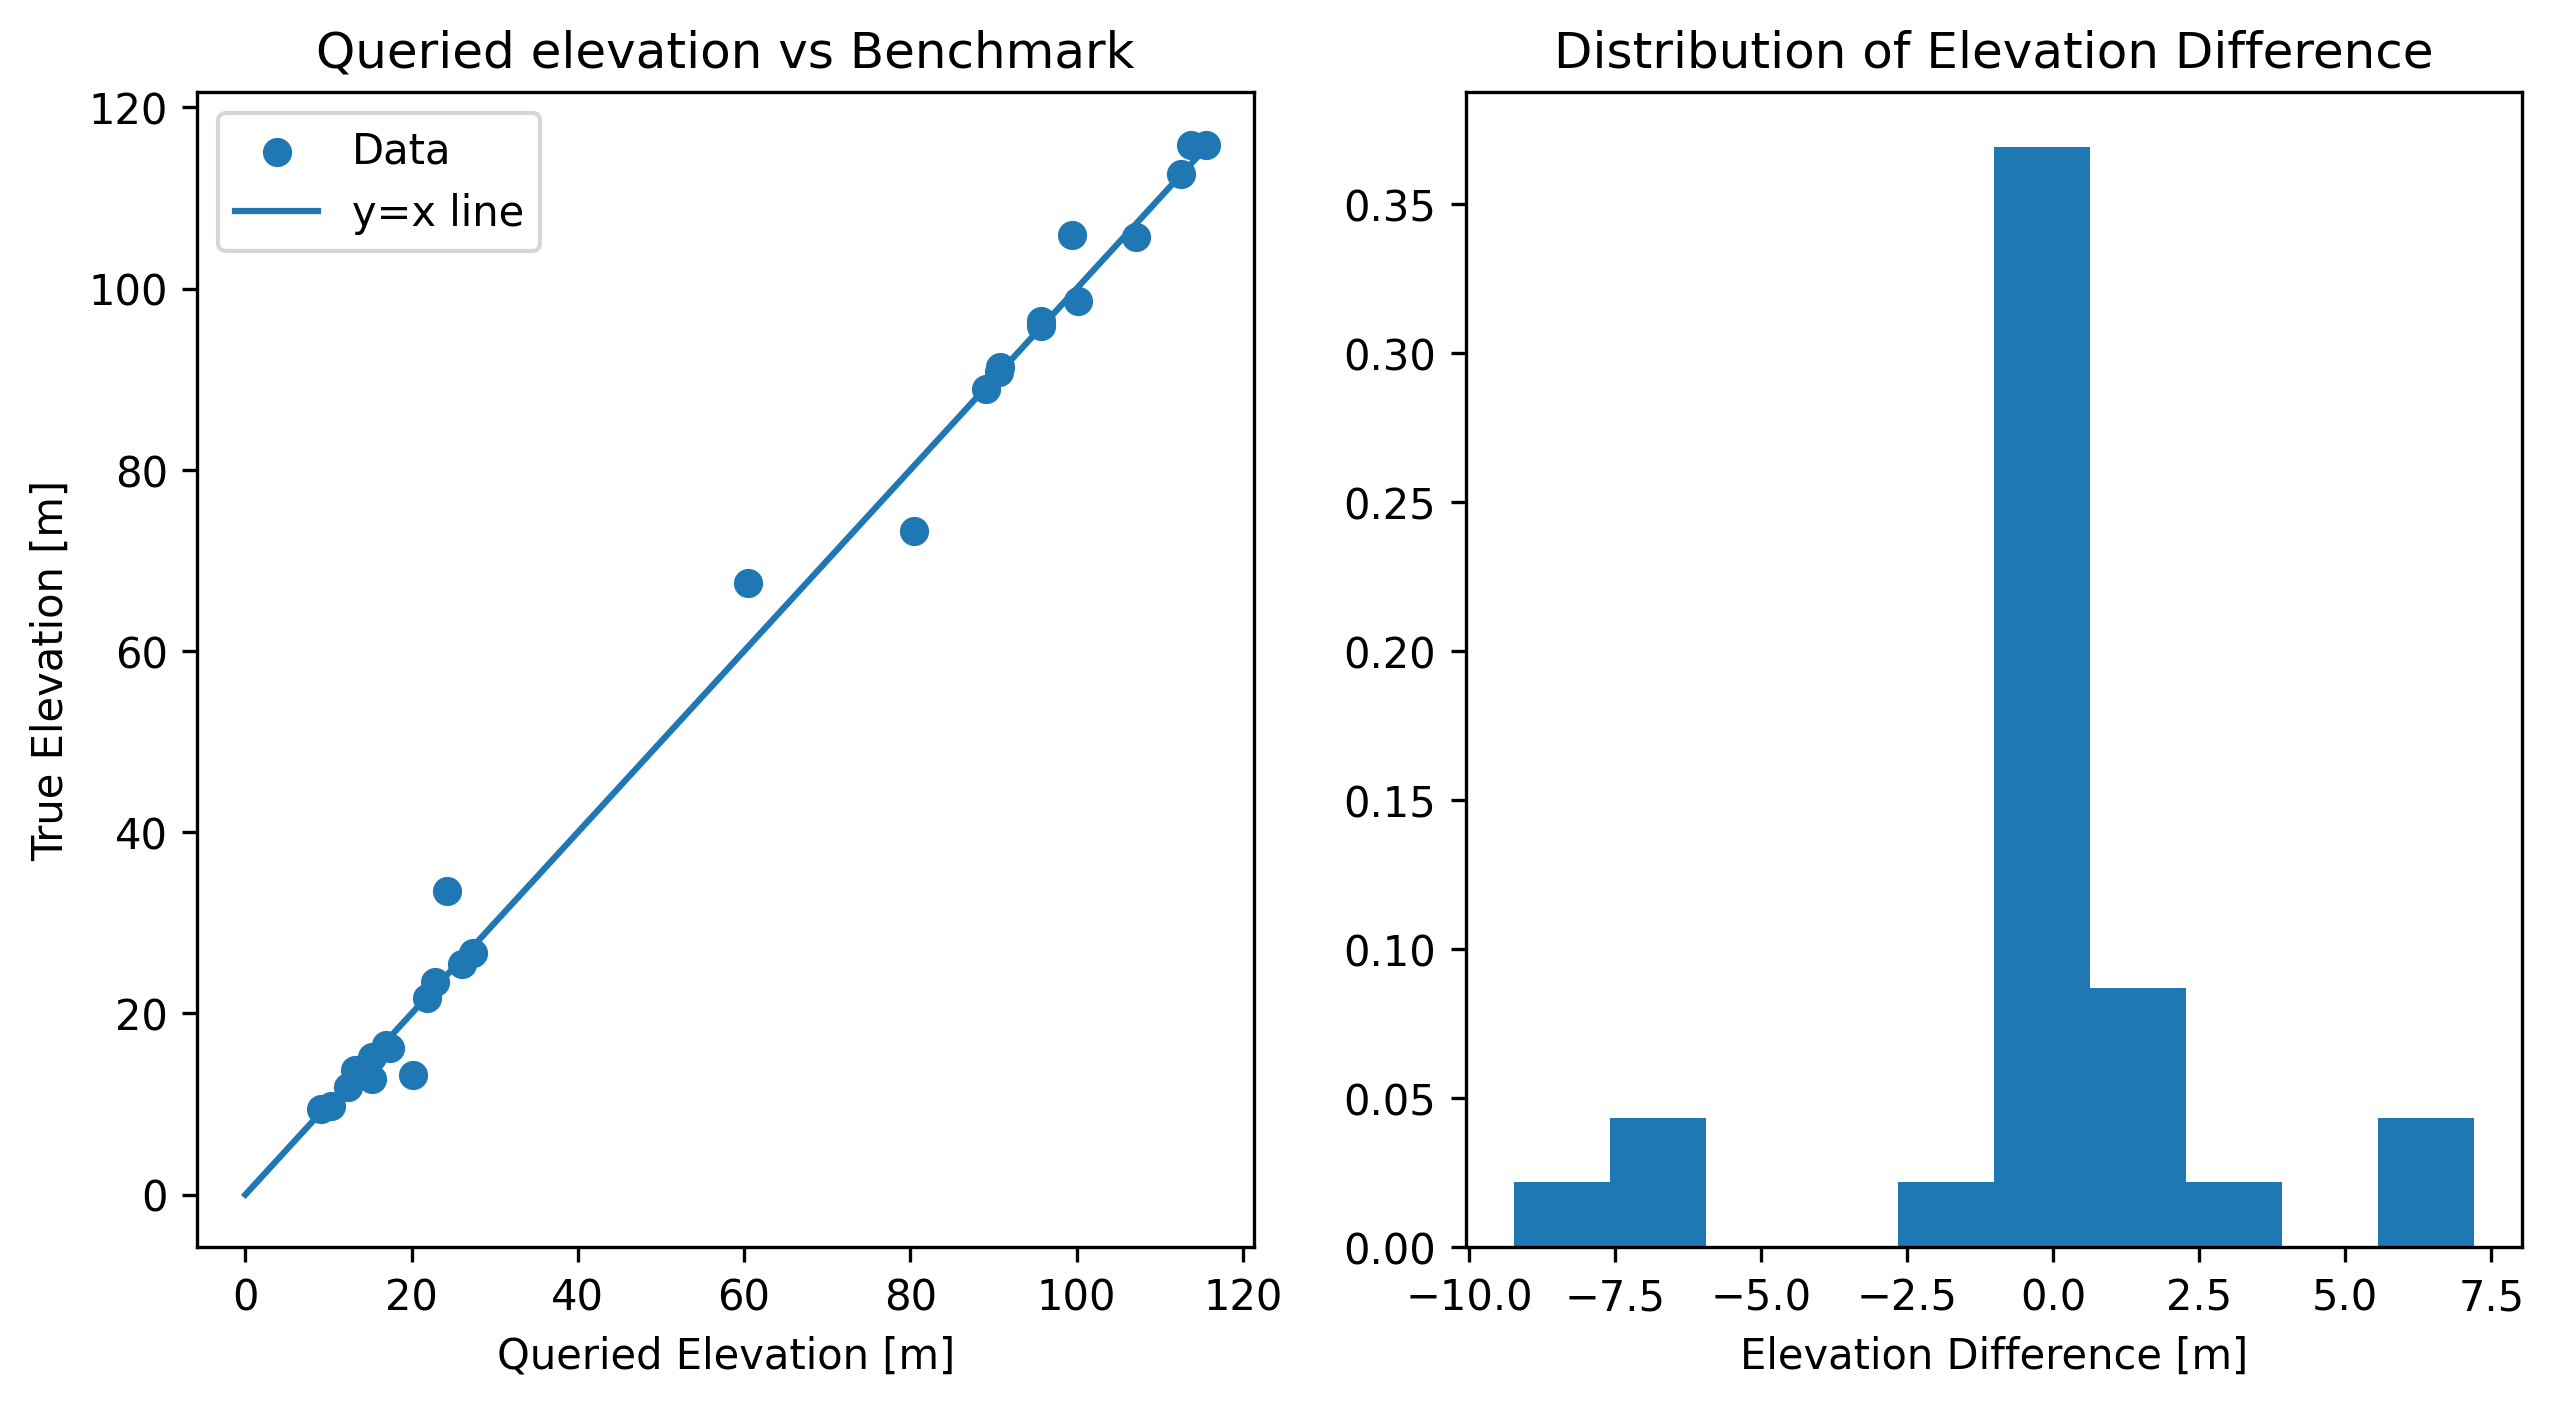

Mean elevation difference: -0.15572738391331115
STDEV elevation difference: 3.3056195007648714


In [37]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 2 ,figsize=(10, 5),dpi=300)
ax[0].scatter(filtered_cols['queried_elevation'], filtered_cols['ELEVATION'].apply(float))
ax[0].plot(np.arange(0, filtered_cols['ELEVATION'].apply(float).max(), 1),
        np.arange(0, filtered_cols['ELEVATION'].apply(float).max(), 1))
diff = filtered_cols['queried_elevation'] - filtered_cols['ELEVATION'].apply(float)
ax[1].hist(diff, density=True)
ax[1].set_title('Distribution of Elevation Difference')
ax[0].set_title('Queried elevation vs Benchmark')
ax[0].legend(['Data', 'y=x line'])
ax[0].set_xlabel('Queried Elevation [m]')
ax[0].set_ylabel('True Elevation [m]')
ax[1].set_xlabel('Elevation Difference [m]')
plt.show()
m = (filtered_cols['queried_elevation'] - filtered_cols['ELEVATION'].apply(float))
sd = m.std()
m = m.mean()
print('Mean elevation difference: {}\nSTDEV elevation difference: {}'.format(m, sd))

And so, we see that the queried elevations, despite being reprojected, are typically .15 meters below the benchmark, and predominantly within about 2.5 meters of the true value. There's also the issue of different resolutions for coordinates, which is tricky to account for with my limited understanding of rasterfiles. But, for our purposes, this is a clear demonstration that the reprojection functions and the elevation is aquirable!<br><br>We can now use the redmond route path I defined earlier to get elevations from!

In [38]:
# First, we convert it to points
route_geometry = route_geodata.apply(lambda x: shapely.Point(x[0],x[1]), axis=1)

# And then we feed it to the function! We also need to remember to convert it from 1/1000 feet to meters.
route_elevations = gt.query_elevation_series(route_geometry, EPSG4326_raster_paths)*1000*.3048
route_elevations

array([31.18098745, 25.95659238, 15.87397642, 12.8497459 , 14.86729484,
       18.07085744, 22.88079873, 13.01053143, 21.96273384, 18.16031826,
       16.54006599])

But, how do we know for certain this is representative of the landscape? Well, we don't. That's why we have to plot it versus geodesic distance. Now, that calculation is wrapped in the query_distance_traveled() function, which allows you to get the geodesic distances as a series!

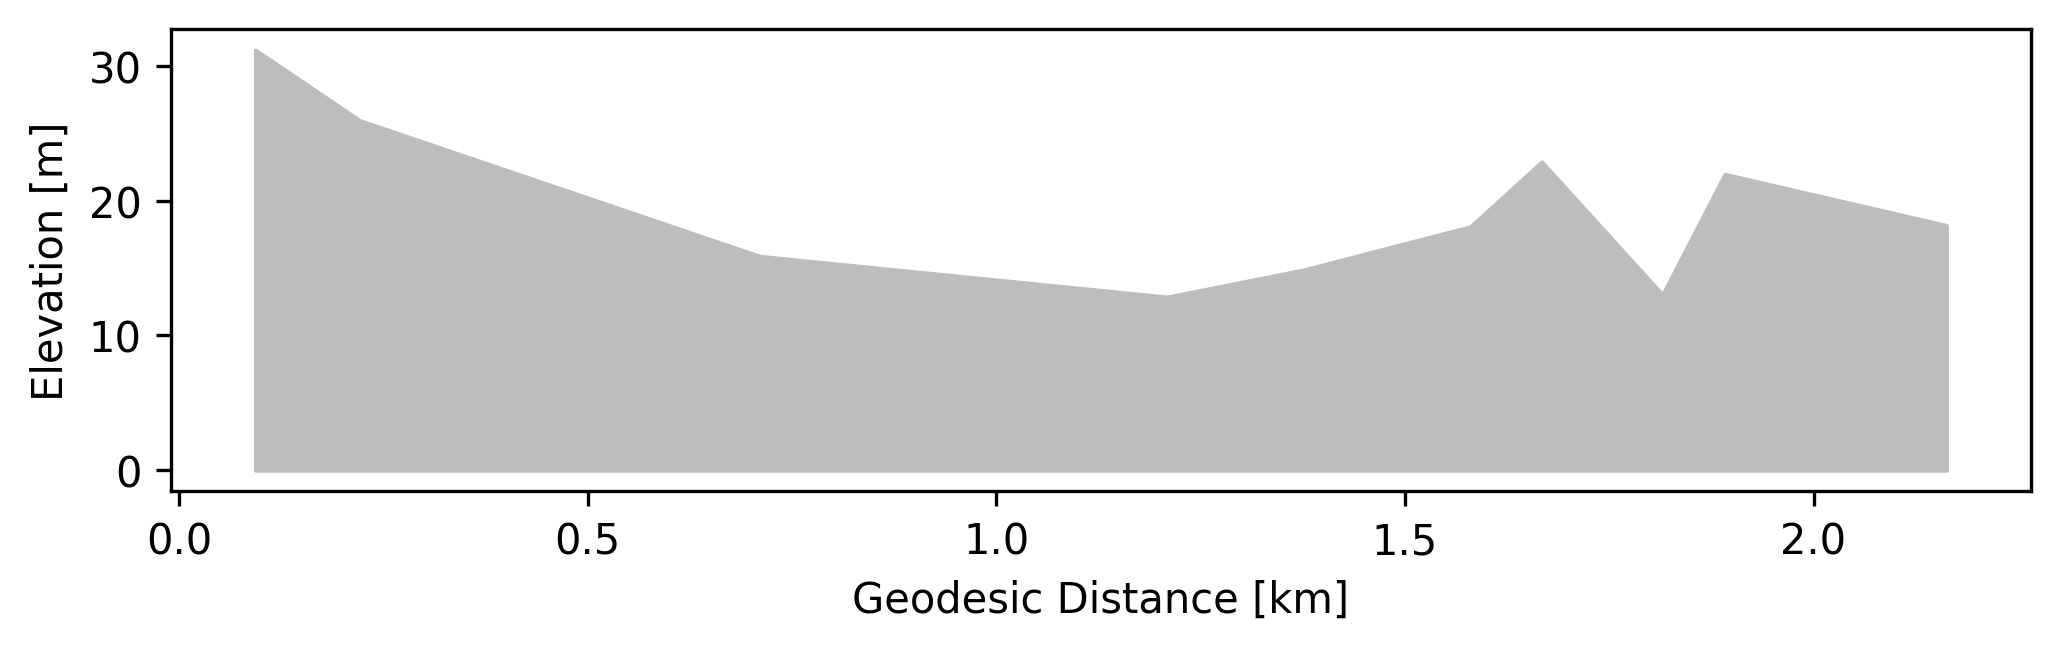

In [39]:
fig, ax = plt.subplots(1, 1, figsize = (8, 2), dpi=300)
ax.fill_between(gt.query_distance_traveled(route_geometry).cumsum(), route_elevations, color = '#BDBDBD')
ax.set_xlabel("Geodesic Distance [km]")
ax.set_ylabel("Elevation [m]")
plt.show()

As we can see, there are some VERY sharp jumps in elevation! So, this is probably not representative. You may have guessed this, but that's on purpose. This is actually a segment of highway going past the north of Marymoor Park in Redmond that has a number of overpasses. As it so happens, the DTM, while managing to avoid trees and cars causing noise in the elevation data, has large gaps where bridges and other human-made road structures would fall off. Here's a map of the points and the area:

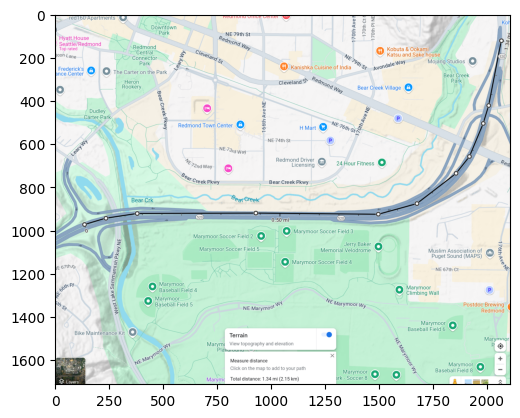

In [40]:
import matplotlib.image as mpimg
img = mpimg.imread('./KC_Example_Data/Misc/redmond_gmaps.png')
imgplot = plt.imshow(img)
plt.show()

And the following is the data we are using for elevation:

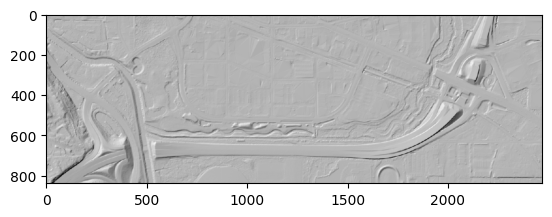

In [41]:
img = mpimg.imread('./KC_Example_Data/Misc/redmond_dtm.png')
imgplot = plt.imshow(img)
plt.show()

So, if our data is limited to what I gave you initially, we can't actually say our elevation is properly accounted for!! What do we do?!
Well...

---
## interpolate_geometry_series()
Like what it says on the tin. You pass it an iterable of shapely geospatial points, and then 
interpolates them such that whatever maximum distance you provide it isn't exceeded!

In [42]:
# We'll say that the maximum distance allowed without interpolation is 10 meters. So, if the distance between points is greater than 10 meters,
# points will be interpolated such that the minimum distance is met. 
# this CAN result in varying distances between interpolated segments, so be warned. 

interpolated_route_geom = gt.interpolate_geometry_series(route_geometry, max_distance=10)
interpolated_route_geom

0      POINT (47.667 -122.129)
1      POINT (47.667 -122.129)
2      POINT (47.667 -122.128)
3      POINT (47.667 -122.128)
4      POINT (47.667 -122.128)
                ...           
217    POINT (47.673 -122.106)
218    POINT (47.674 -122.106)
219    POINT (47.674 -122.106)
220    POINT (47.674 -122.106)
221    POINT (47.674 -122.106)
Length: 222, dtype: geometry

In [43]:
# And then, we can use the query_distance_traveled method again to see those distances!
dx_between_points = gt.query_distance_traveled(interpolated_route_geom)
dx_between_points

array([0.00933857, 0.00933857, 0.00933856, 0.00933856, 0.00933856,
       0.00933855, 0.00933855, 0.00933855, 0.00933854, 0.00933854,
       0.00979845, 0.00979845, 0.00979845, 0.00979844, 0.00979844,
       0.00979844, 0.00979844, 0.00979843, 0.00979843, 0.00979843,
       0.00979842, 0.00979842, 0.00979842, 0.00999352, 0.00999352,
       0.00999352, 0.00999352, 0.00999351, 0.00999351, 0.00999351,
       0.00999351, 0.00999351, 0.00999351, 0.00999351, 0.00999351,
       0.00999351, 0.00999351, 0.00999351, 0.00999351, 0.00999351,
       0.00999351, 0.00999351, 0.00999351, 0.00999351, 0.00999351,
       0.00999351, 0.00999351, 0.00999351, 0.00999351, 0.00999351,
       0.00999351, 0.00999351, 0.00999351, 0.00999351, 0.00999351,
       0.00999351, 0.00999351, 0.00999351, 0.00999351, 0.00999351,
       0.00999351, 0.00999351, 0.00999351, 0.00999351, 0.00999351,
       0.00999351, 0.00999351, 0.00999351, 0.00999351, 0.00999351,
       0.00999351, 0.00999351, 0.00997401, 0.00997401, 0.00997

And as we can see, the point distances are approximately all 14.6 meters apart. As I mentioned eariler, it's interpolating _if the maximum distance is exceeded_. It will do its best to get close to that distance, 
but given the distance between points can vary and therefore may not be able to be split up very evenly, it won't be perfect. 
Putting that aside, let's take a look at how the elevation looks with this set of points instead!

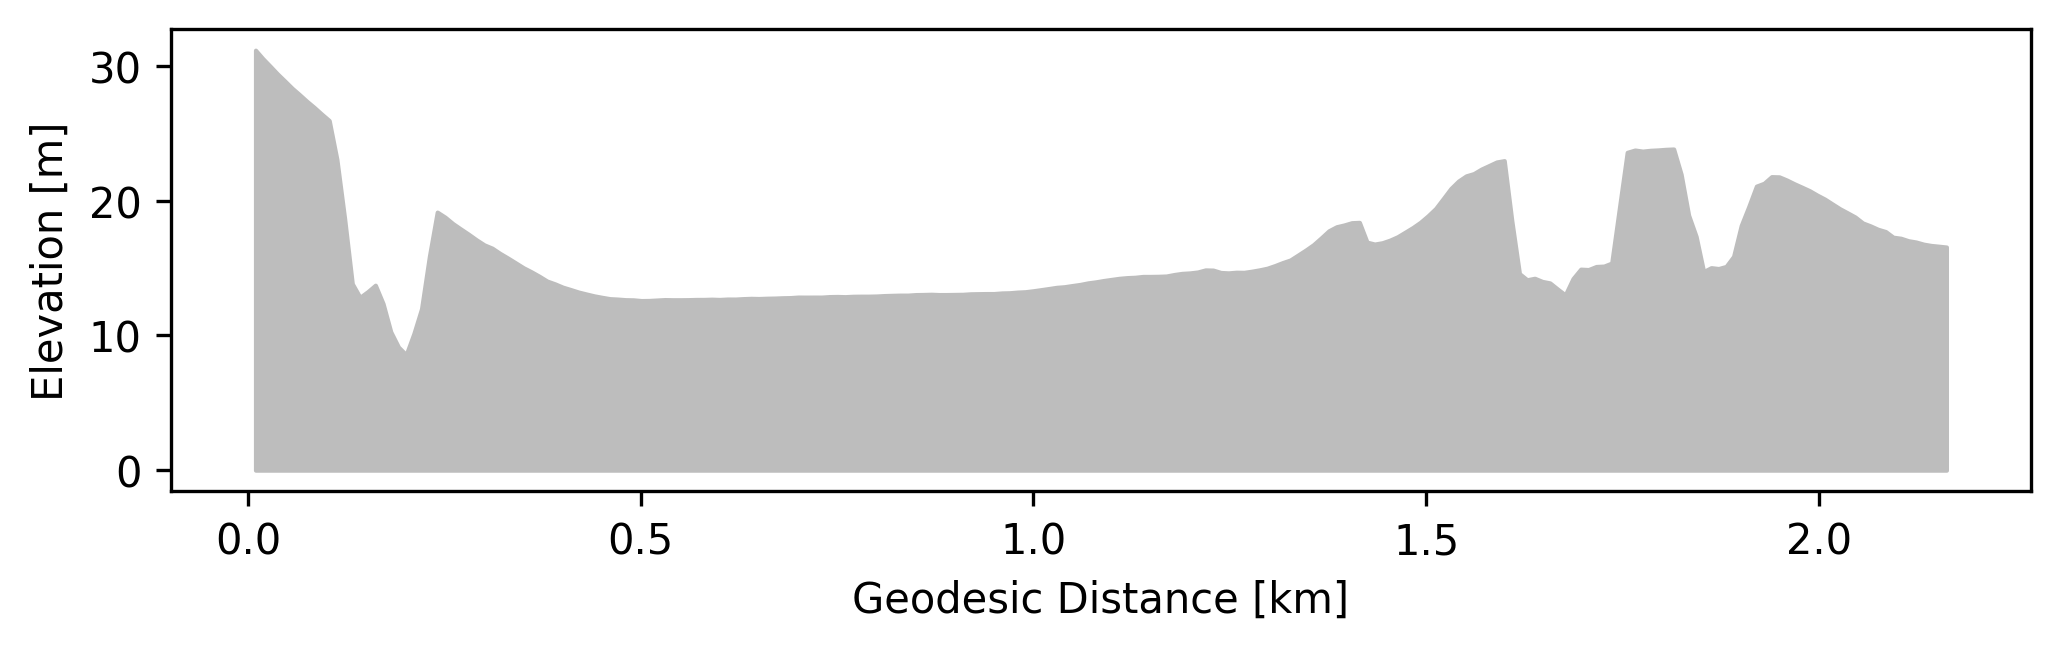

In [44]:
interpolated_elev = gt.query_elevation_series(interpolated_route_geom, EPSG4326_raster_paths)*1000*.3048

fig, ax = plt.subplots(1, 1, figsize = (8, 2), dpi=300)
ax.fill_between(dx_between_points.cumsum(), interpolated_elev, color = '#BDBDBD')
ax.set_xlabel("Geodesic Distance [km]")
ax.set_ylabel("Elevation [m]")
plt.show()

Gasp! We can see pretty clearly that there are those gaps! That's why it's important to make sure we have all of the adequate data. 
But how do we deal with those gaps? How do we deal with the noise? While we're at it, let's characterize the grade of the slope to see if its within the expected bounds of a ~7.5% grade slope.

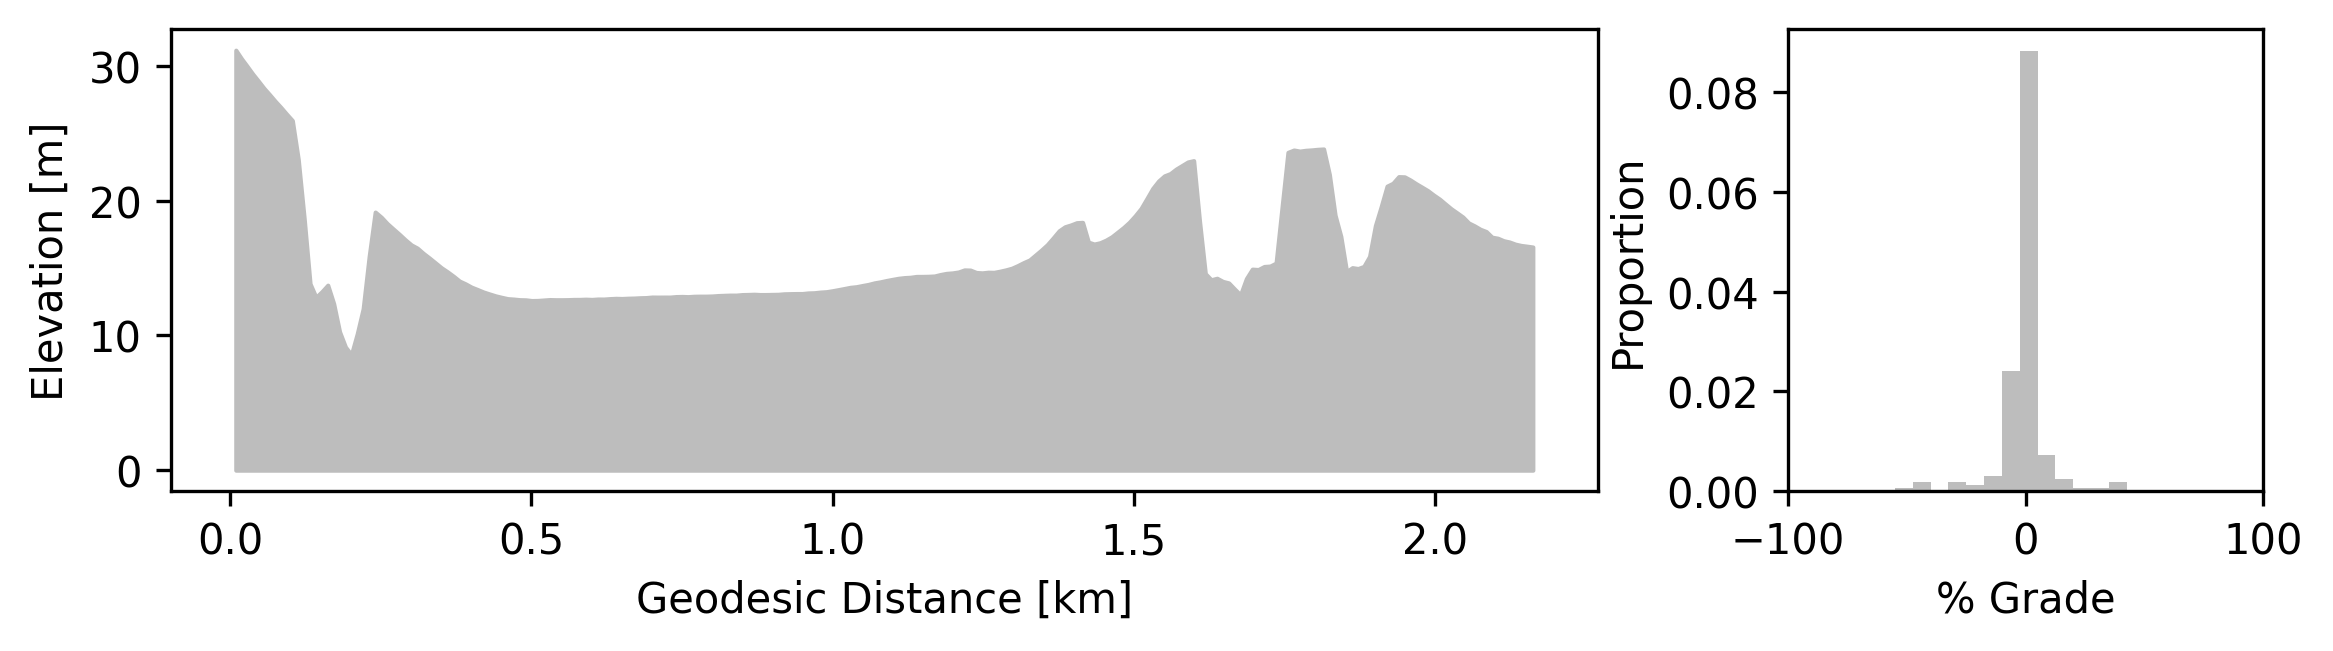

In [45]:
# We're turning clipping off, as we want to see how it changes overall!
grades = gt.calculate_grades(dx_between_points, interpolated_elev/1000, clip=False) #DONT FORGET TO USE THE SAME UNITS!!!
bins = np.arange(-100, 100, 7.5)
fig, ax = plt.subplots(1, 2, figsize = (9, 2), dpi=300, gridspec_kw={'width_ratios': [3, 1]})
ax[0].fill_between(dx_between_points.cumsum(), interpolated_elev, color = '#BDBDBD')
ax[0].set_xlabel("Geodesic Distance [km]")
ax[0].set_ylabel("Elevation [m]")
ax[1].hist(grades,bins=bins, density=True, color='#BDBDBD')
ax[1].set_xlabel('% Grade')
ax[1].set_ylabel('Proportion')
ax[1].set_xlim(-100, 100)
plt.show()

Yep. That's some janky grades, for sure. 

---
## smooth_elevation()
Smooth elevation is basically a wrapper for scipy's savisky-golay filter, which is used to help reduce noise in data. So, if we
want to try and smooth this, let's give it a shot. 

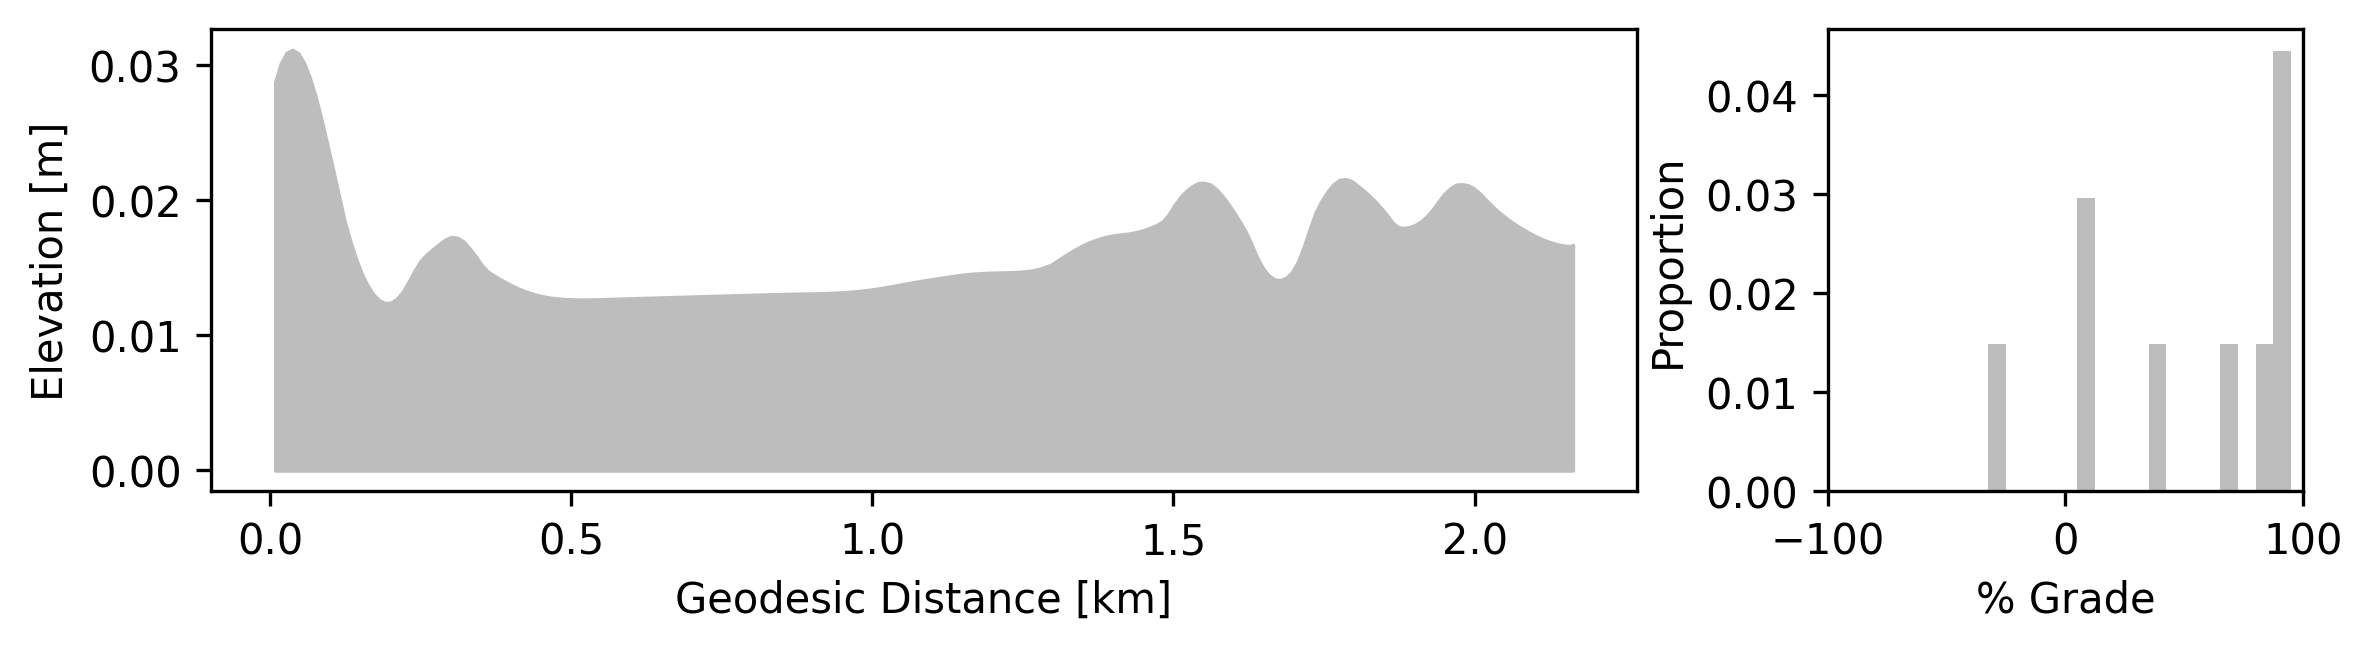

In [46]:
# We'll use a 3rd degree, over 40 points. 
smoothed_elev = gt.smooth_elevation(interpolated_elev, lg=25, deg=3)
sm_grades = gt.calculate_grades(dx_between_points, smoothed_elev, clip=False)

fig, ax = plt.subplots(1, 2, figsize = (9, 2), dpi=300, gridspec_kw={'width_ratios': [3, 1]})
ax[0].fill_between(dx_between_points.cumsum(), smoothed_elev/1000, color = '#BDBDBD')
ax[0].set_xlabel("Geodesic Distance [km]")
ax[0].set_ylabel("Elevation [m]")
ax[1].hist(sm_grades,bins=bins, density=True, color='#BDBDBD')
ax[1].set_xlabel('% Grade')
ax[1].set_ylabel('Proportion')
ax[1].set_xlim(-100, 100)
plt.show()


Well gosh, that certainly smoothed the data - and the grades are looking a bit more consolidated, rather than spread out oer a range on the order of 20,000.
However, this still isn't really good enough. This will 100% depend on the extent of your data. What happens if we use the DSM data, instead?

Let's take a look at the Digital Surface Model instead, and see if it's any better. 

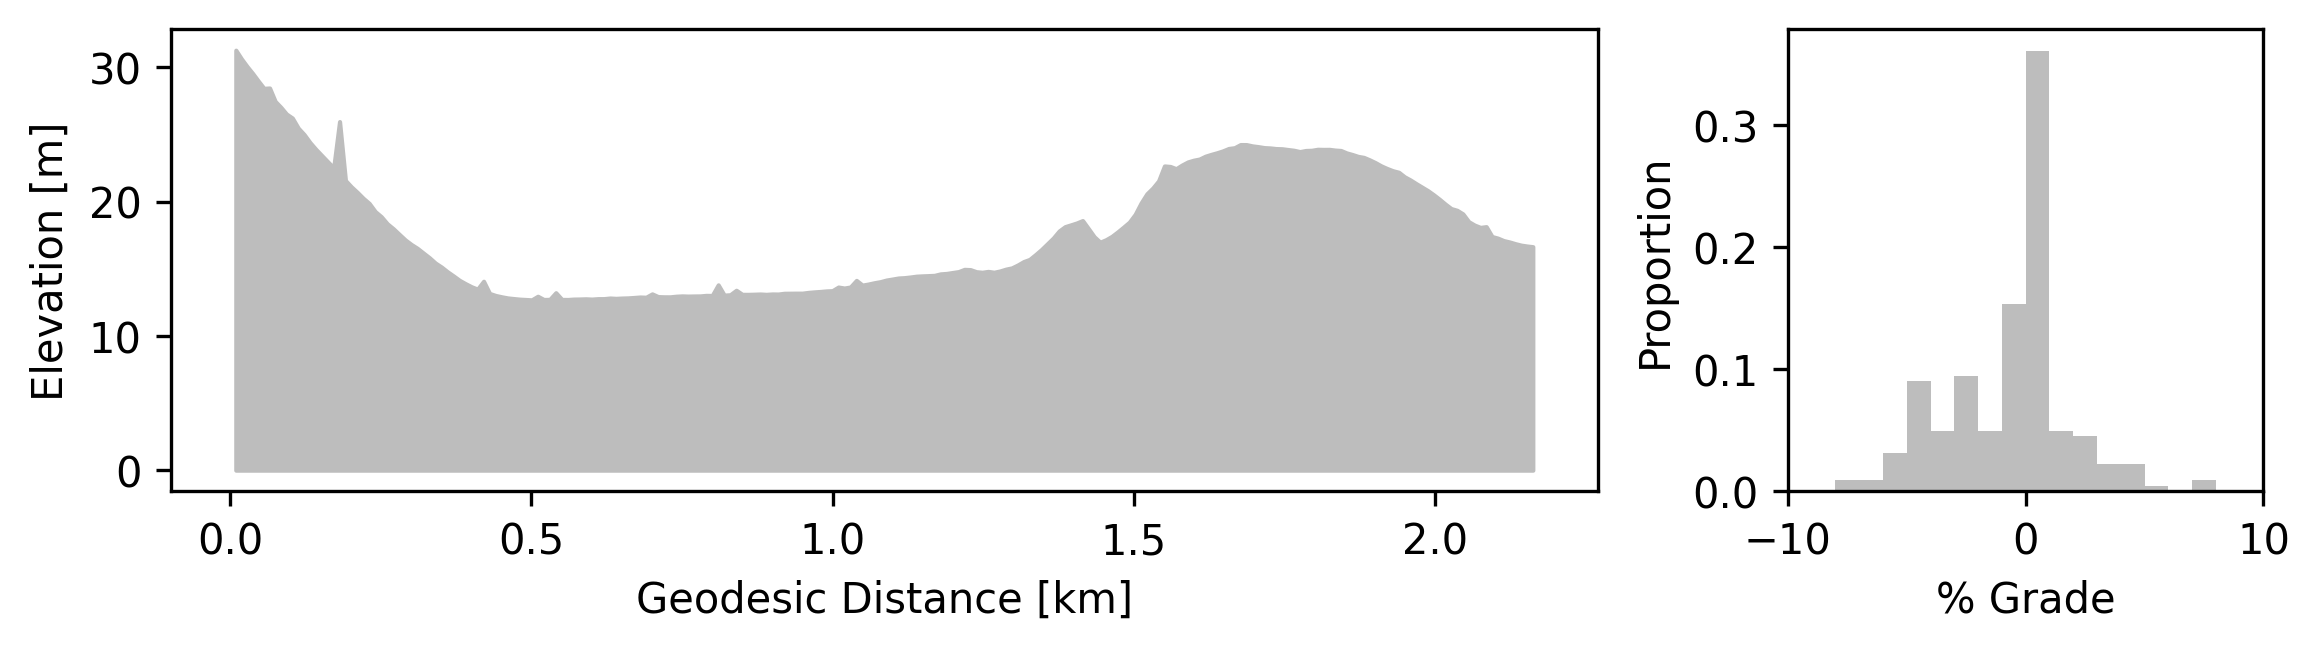

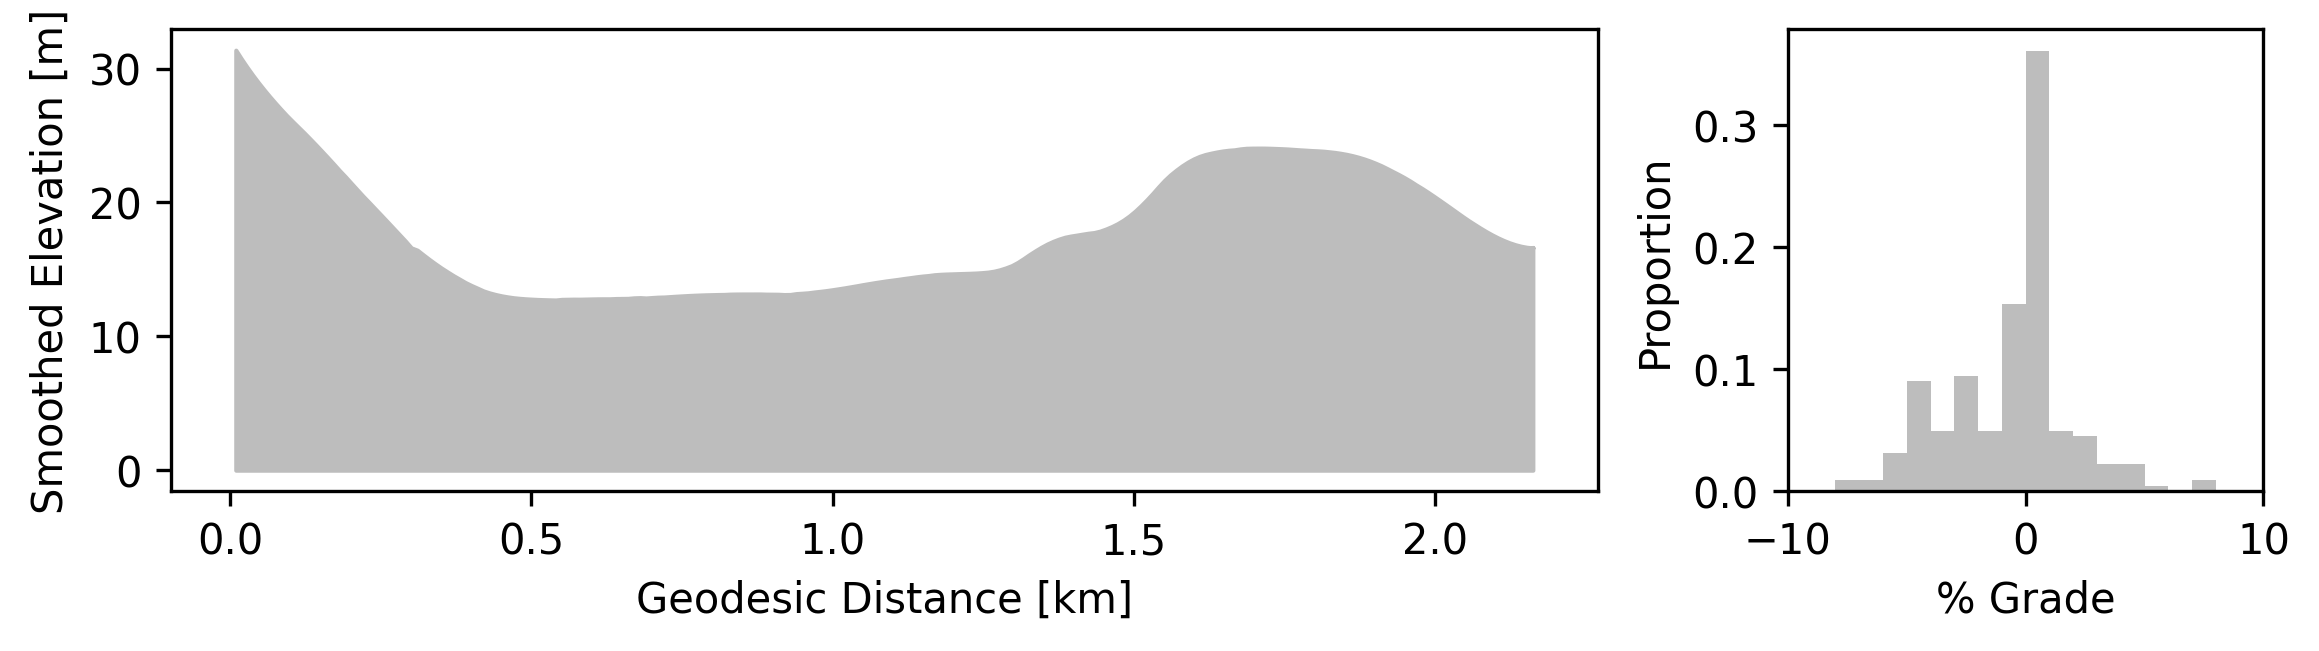

In [47]:
dsm_raster_path =  "./KC_Example_Data/Example_Raster_Data/Redmond_2014/dsm/"
dsm_path_list = gt.get_rasterfiles(dsm_raster_path)
dsm_raster_paths = gt.reproject_rasterfiles(dsm_path_list, target_crs='EPSG:4326')
bins = np.arange(-10, 10, 1)
idsm_elev = gt.query_elevation_series(interpolated_route_geom, dsm_raster_paths)*1000*.3048
smoothed_dsm_elev = gt.smooth_elevation(idsm_elev, lg=25, deg=3)
dsm_sm_grades = gt.calculate_grades(dx_between_points, smoothed_dsm_elev/1000, clip=False)


fig, ax = plt.subplots(1, 2, figsize = (9, 2), dpi=300, gridspec_kw={'width_ratios': [3, 1]})
ax[0].fill_between(dx_between_points.cumsum(), idsm_elev, color = '#BDBDBD')
ax[0].set_xlabel("Geodesic Distance [km]")
ax[0].set_ylabel("Elevation [m]")
ax[1].hist(dsm_sm_grades,bins=bins, density=True, color='#BDBDBD')
ax[1].set_xlabel('% Grade')
ax[1].set_ylabel('Proportion')
ax[1].set_xlim(-10, 10)
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (9, 2), dpi=300, gridspec_kw={'width_ratios': [3, 1]})
ax[0].fill_between(dx_between_points.cumsum(), smoothed_dsm_elev, color = '#BDBDBD')
ax[0].set_xlabel("Geodesic Distance [km]")
ax[0].set_ylabel("Smoothed Elevation [m]")
ax[1].hist(dsm_sm_grades,bins=bins, density=True, color='#BDBDBD')
ax[1].set_xlabel('% Grade')
ax[1].set_ylabel('Proportion')
ax[1].set_xlim(-10, 10)
plt.show()

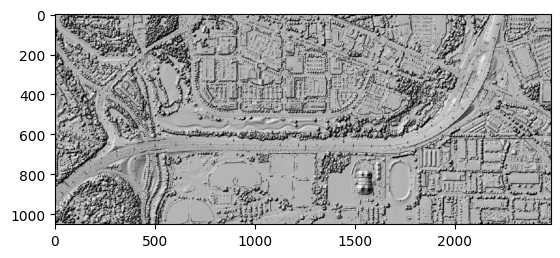

In [48]:
img = mpimg.imread('./KC_Example_Data/Misc/redmond_dsm.png')
imgplot = plt.imshow(img)
plt.show()

Well, hey! That prifile looks downright close to what we would expect to see from this segment and it's overpass, save for a bit of jank here and there. 
The grades are even mostly within the expected bounds of -7.5 to -7.5! But, just to be sure, we can help remove outliers by using clip=True. Clipping allows us to set any grades exceeding 7.5 (or another desired number) to that set value - as we can expect that no grade will exceed 7.5% on this stretch of road per king county guidelines. 

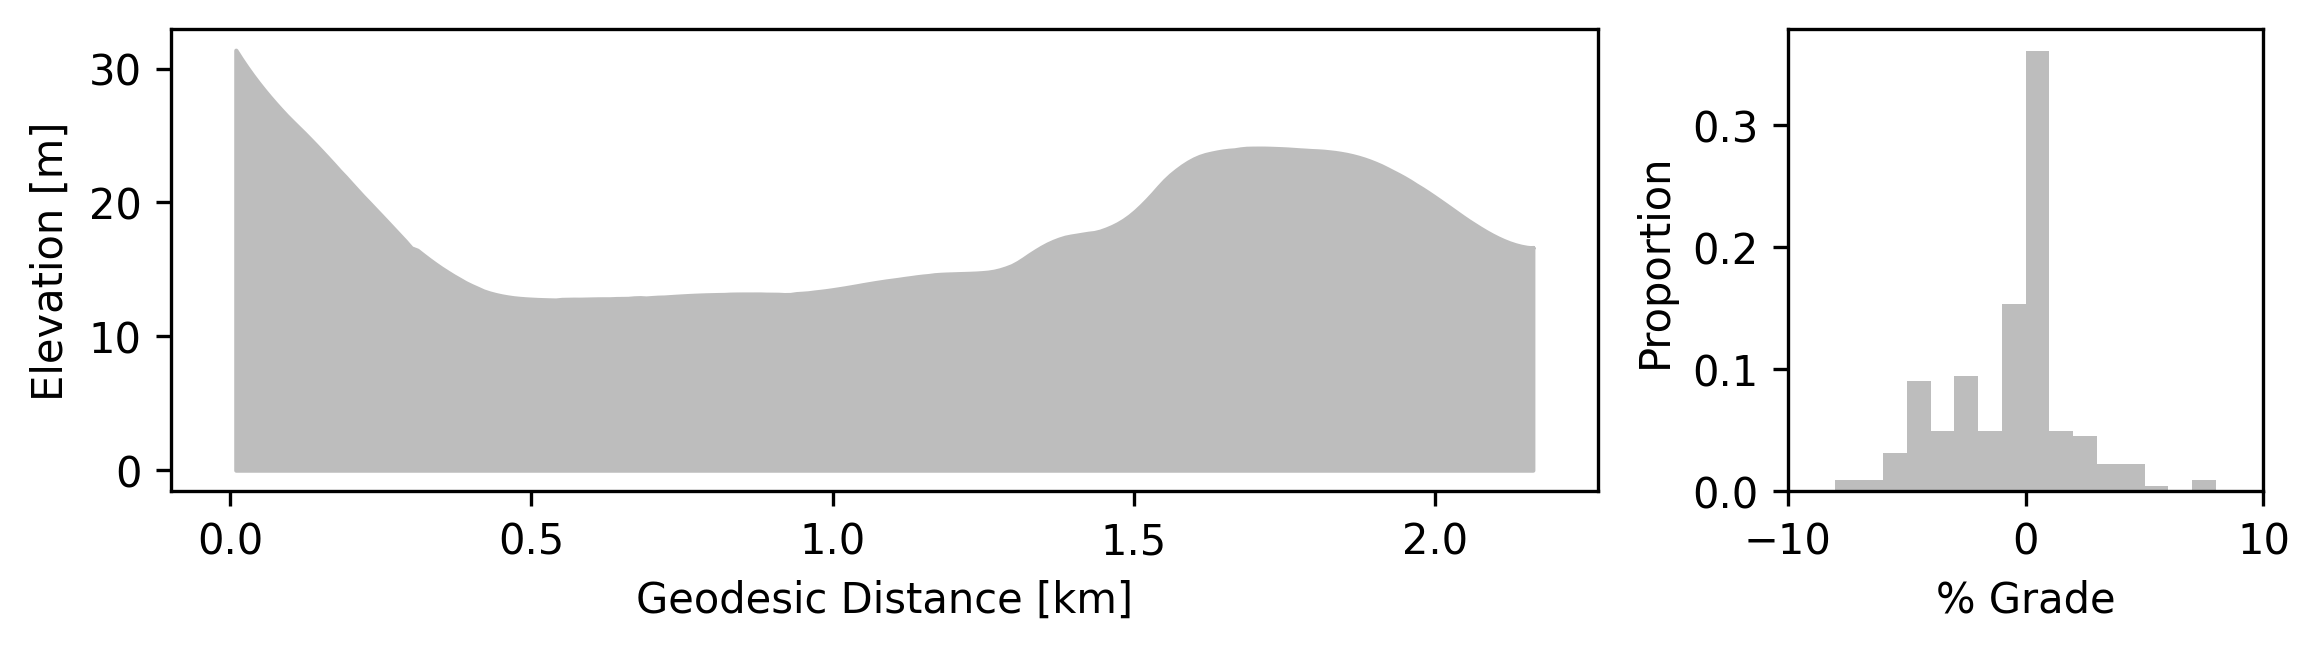

In [49]:
dsm_raster_path =  "./KC_Example_Data/Example_Raster_Data/Redmond_2014/dsm/"
dsm_path_list = gt.get_rasterfiles(dsm_raster_path)
dsm_raster_paths = gt.reproject_rasterfiles(dsm_path_list, target_crs='EPSG:4326')
bins = np.arange(-10, 10, 1)
idsm_elev = gt.query_elevation_series(interpolated_route_geom, dsm_raster_paths)*1000*.3048
smoothed_dsm_elev = gt.smooth_elevation(idsm_elev, lg=25, deg=3)
dsm_sm_grades = gt.calculate_grades(dx_between_points, smoothed_dsm_elev/1000, clip=True)# <--- We have changed clip to True

fig, ax = plt.subplots(1, 2, figsize = (9, 2), dpi=300, gridspec_kw={'width_ratios': [3, 1]})
ax[0].fill_between(dx_between_points.cumsum(), smoothed_dsm_elev, color = '#BDBDBD')
ax[0].set_xlabel("Geodesic Distance [km]")
ax[0].set_ylabel("Elevation [m]")
ax[1].hist(dsm_sm_grades,bins=bins, density=True, color='#BDBDBD')
ax[1].set_xlabel('% Grade')
ax[1].set_ylabel('Proportion')
ax[1].set_xlim(-10, 10)
plt.show()

Now, it's pretty clear there's a stark difference between the DTM and DSM in how well they're able to accurately model the landscape. While you may have your own elevation data, it's important to consider that there are different types. Because of this, we should compare the results we get with the Digital Surface Model versus the results of the Digital Terrain Model. Let's go back to the benchmarks, real quick. <br><br> First things first, we're going to query the DSM elevation.

In [30]:
# Rename the column for clarity's sake
filtered_cols = filtered_cols.rename(columns={'queried_elevation':'DTM_elevation'})
filtered_cols['DSM_elevation'] = gt.query_elevation_series(filtered_cols['geometry'], dsm_raster_paths)*1000*.3048

In [33]:
# Now, we're going to do linear fits of both the DTM and DSM benchmarks
import scipy.optimize
def fit_linear_data(xdata, ydata):
    def linfunc(x, m, b):
        y=m*x+b
        return y
    parameters, covariance = scipy.optimize.curve_fit(linfunc, xdata, ydata)
    pred_y = linfunc(xdata, parameters[0], parameters[1])
    squared_res = ((pred_y-ydata)**2).sum()
    total_squares = ((ydata-ydata.mean())**2).sum()
    MSE = ((pred_y-ydata)**2).mean()
    r_squared = 1-(squared_res/total_squares)
    return parameters, MSE, r_squared, pred_y

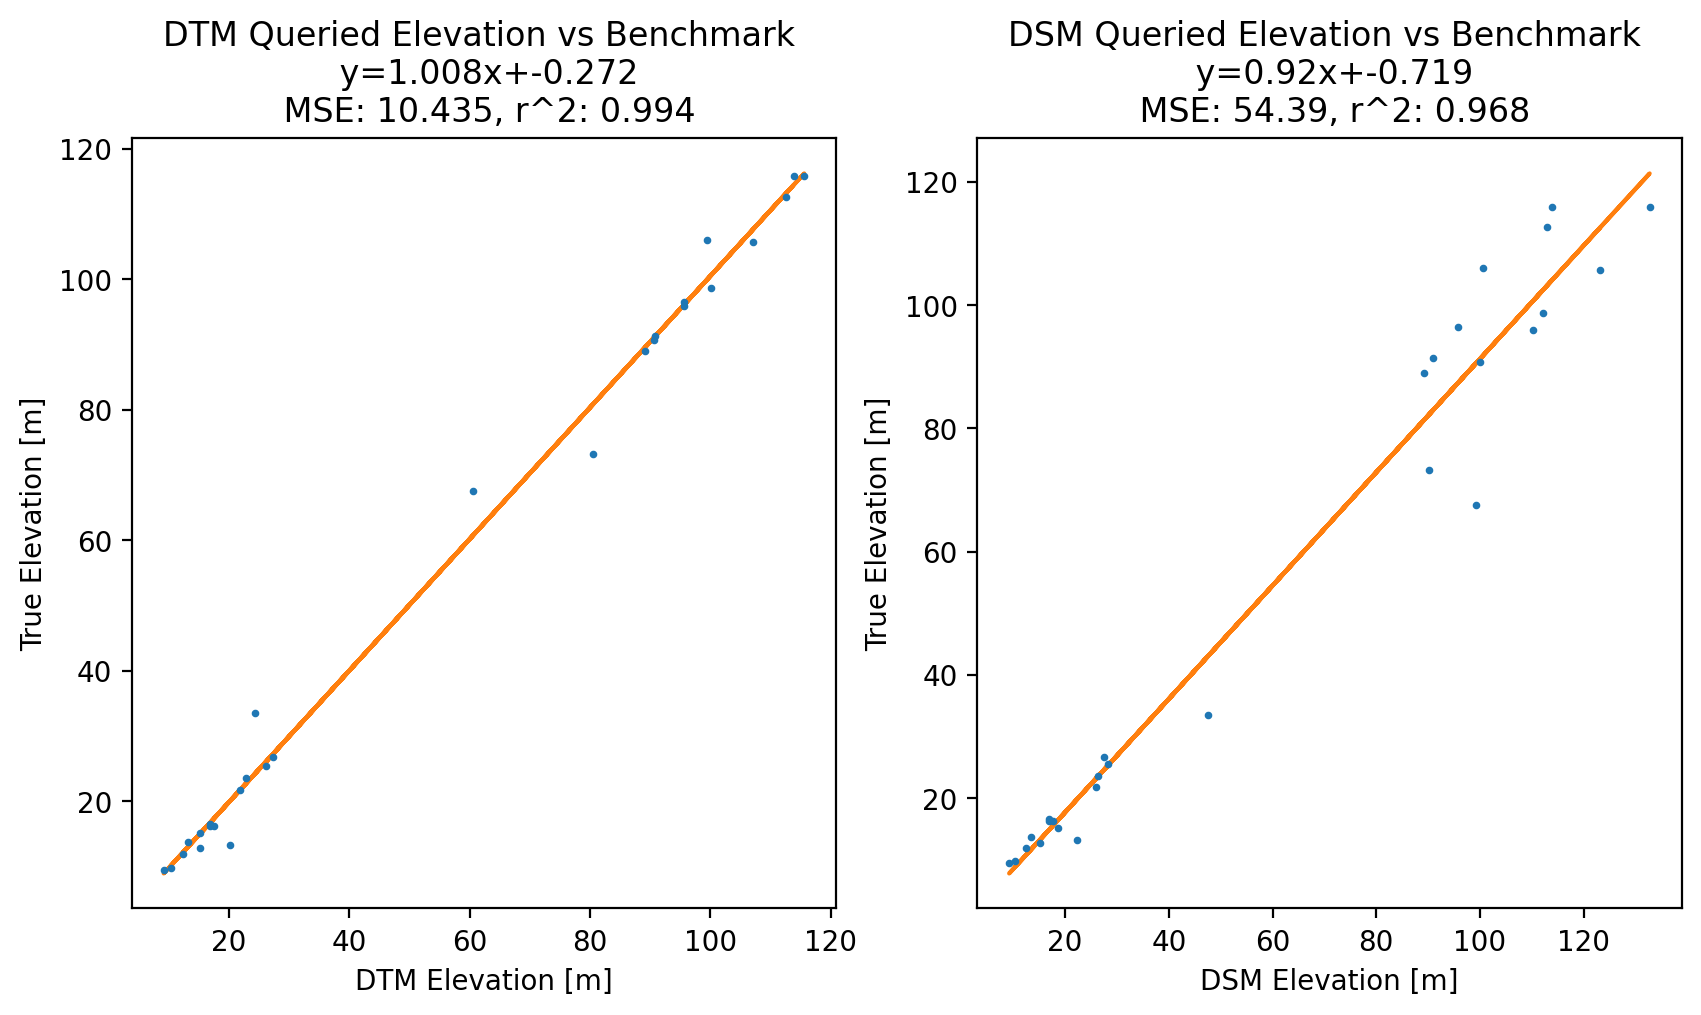

In [34]:
dtm_params, dtm_MSE, dtm_r2, dtm_mod = fit_linear_data(filtered_cols['DTM_elevation'], filtered_cols['ELEVATION'].apply(float))
dsm_params, dsm_MSE, dsm_r2, dsm_mod = fit_linear_data(filtered_cols['DSM_elevation'], filtered_cols['ELEVATION'].apply(float))

fig, ax = plt.subplots(1, 2, figsize = (10, 5), dpi=200)
ax[0].set_title('DTM Queried Elevation vs Benchmark \n y={}x+{}\n MSE: {}, r^2: {}'.format(round(dtm_params[0],3), round(dtm_params[1],3), round(dtm_MSE,3), round(dtm_r2,3)))
ax[0].set_xlabel('DTM Elevation [m]')
ax[0].set_ylabel('True Elevation [m]')
ax[0].scatter(filtered_cols['DTM_elevation'], filtered_cols['ELEVATION'].apply(float), zorder=2, s=3)
ax[0].plot(filtered_cols['DTM_elevation'], dtm_mod, c='tab:orange',zorder=1)

ax[1].set_title('DSM Queried Elevation vs Benchmark \n y={}x+{}\n MSE: {}, r^2: {}'.format(round(dsm_params[0],3), round(dsm_params[1],3), round(dsm_MSE,3), round(dsm_r2,3)))
ax[1].set_xlabel('DSM Elevation [m]')
ax[1].set_ylabel('True Elevation [m]')
ax[1].scatter(filtered_cols['DSM_elevation'], filtered_cols['ELEVATION'].apply(float), zorder=2, s=3)
ax[1].plot(filtered_cols['DSM_elevation'], dsm_mod, c='tab:orange',zorder=1)
plt.show()

Now, while it is true that the benchmarks have significantly more variability and error for the DSM, it is important to note that this cannot account for the DSM picking up noise from trees. Given the benchmarks are placed in the ground, it makes sense the benchmarks are significantly more accurate to the DTM. Despite this accuracy, I would reccomend using DSM's and filtering the elevation noise out instead, as bridges are large enough such that they wouldn't be able to get smoothed over and as such represent a significant loss in accuracy. 

## Stops, Signals, and Speed Limits
Now, we've got our geospatial points and our corresponding elevations. However, when it comes to understanding road dynamics and driving expectations, knowing where bus stops, signals, and speed limits should be assigned is critical. For that, there are the methods query_stops(), query_signals(), and query_speed_limits(). All three of these function on essentially the same principle. They need some value, wether it be a stop ID, signal ID, or speed limit, and the geometry of all of those. We'll use query_speed_limits to explain how it works.

In [35]:
# First, we need some speed limit data. We'll use the King County Metro streets dataset. Given this is #MASSIVE#,
# It will take a minute or two to load up.
data_path = "./KC_Example_Data/KC_Route_Data/Seattle_Streets/KCM_Streets.shp"

# We can see that it has a geometry column, and our target data of interest, speed limits,
# in the "SPEED_LIM" Column. Also, be sure to check the projection system your data is in, this is
# in epsg 4326. By default, 
speed_limits = gt.query_speed_limits(pd.Series(interpolated_route_geom), data_path, key="SPEED_LIM", epsg=4326)

|████████████████████████████████████████| 222/222 [100%] in 0.5s (478.17/s) 


In [36]:
def flip(x, y):
    """Flips the x and y coordinate values"""
    return y, x

In [37]:
limits = np.asarray(speed_limits)*2236.93629205
gs = gpd.GeoSeries(interpolated_route_geom).apply(lambda x: shapely.ops.transform(flip, x))
d = {'limit': limits, 'geometry': gs}
lim_data = gpd.GeoDataFrame(d, crs="EPSG:4326")
lim_data

,limit,geometry
0,55.0,POINT (-122.1287 47.6669)
1,55.0,POINT (-122.12858 47.66692)
2,55.0,POINT (-122.12846 47.66694)
3,55.0,POINT (-122.12834 47.66697)
4,55.0,POINT (-122.12822 47.66699)
...,...,...
217,55.0,POINT (-122.10597 47.67342)
218,55.0,POINT (-122.10594 47.67351)
219,55.0,POINT (-122.10592 47.67359)
220,55.0,POINT (-122.10589 47.67368)


And now, we have a series of the same length as our geometry that has the speed limits in km/s. Plotting this out on a map, we can see it follows the highway and has the consistent speed limit of 55 mph!

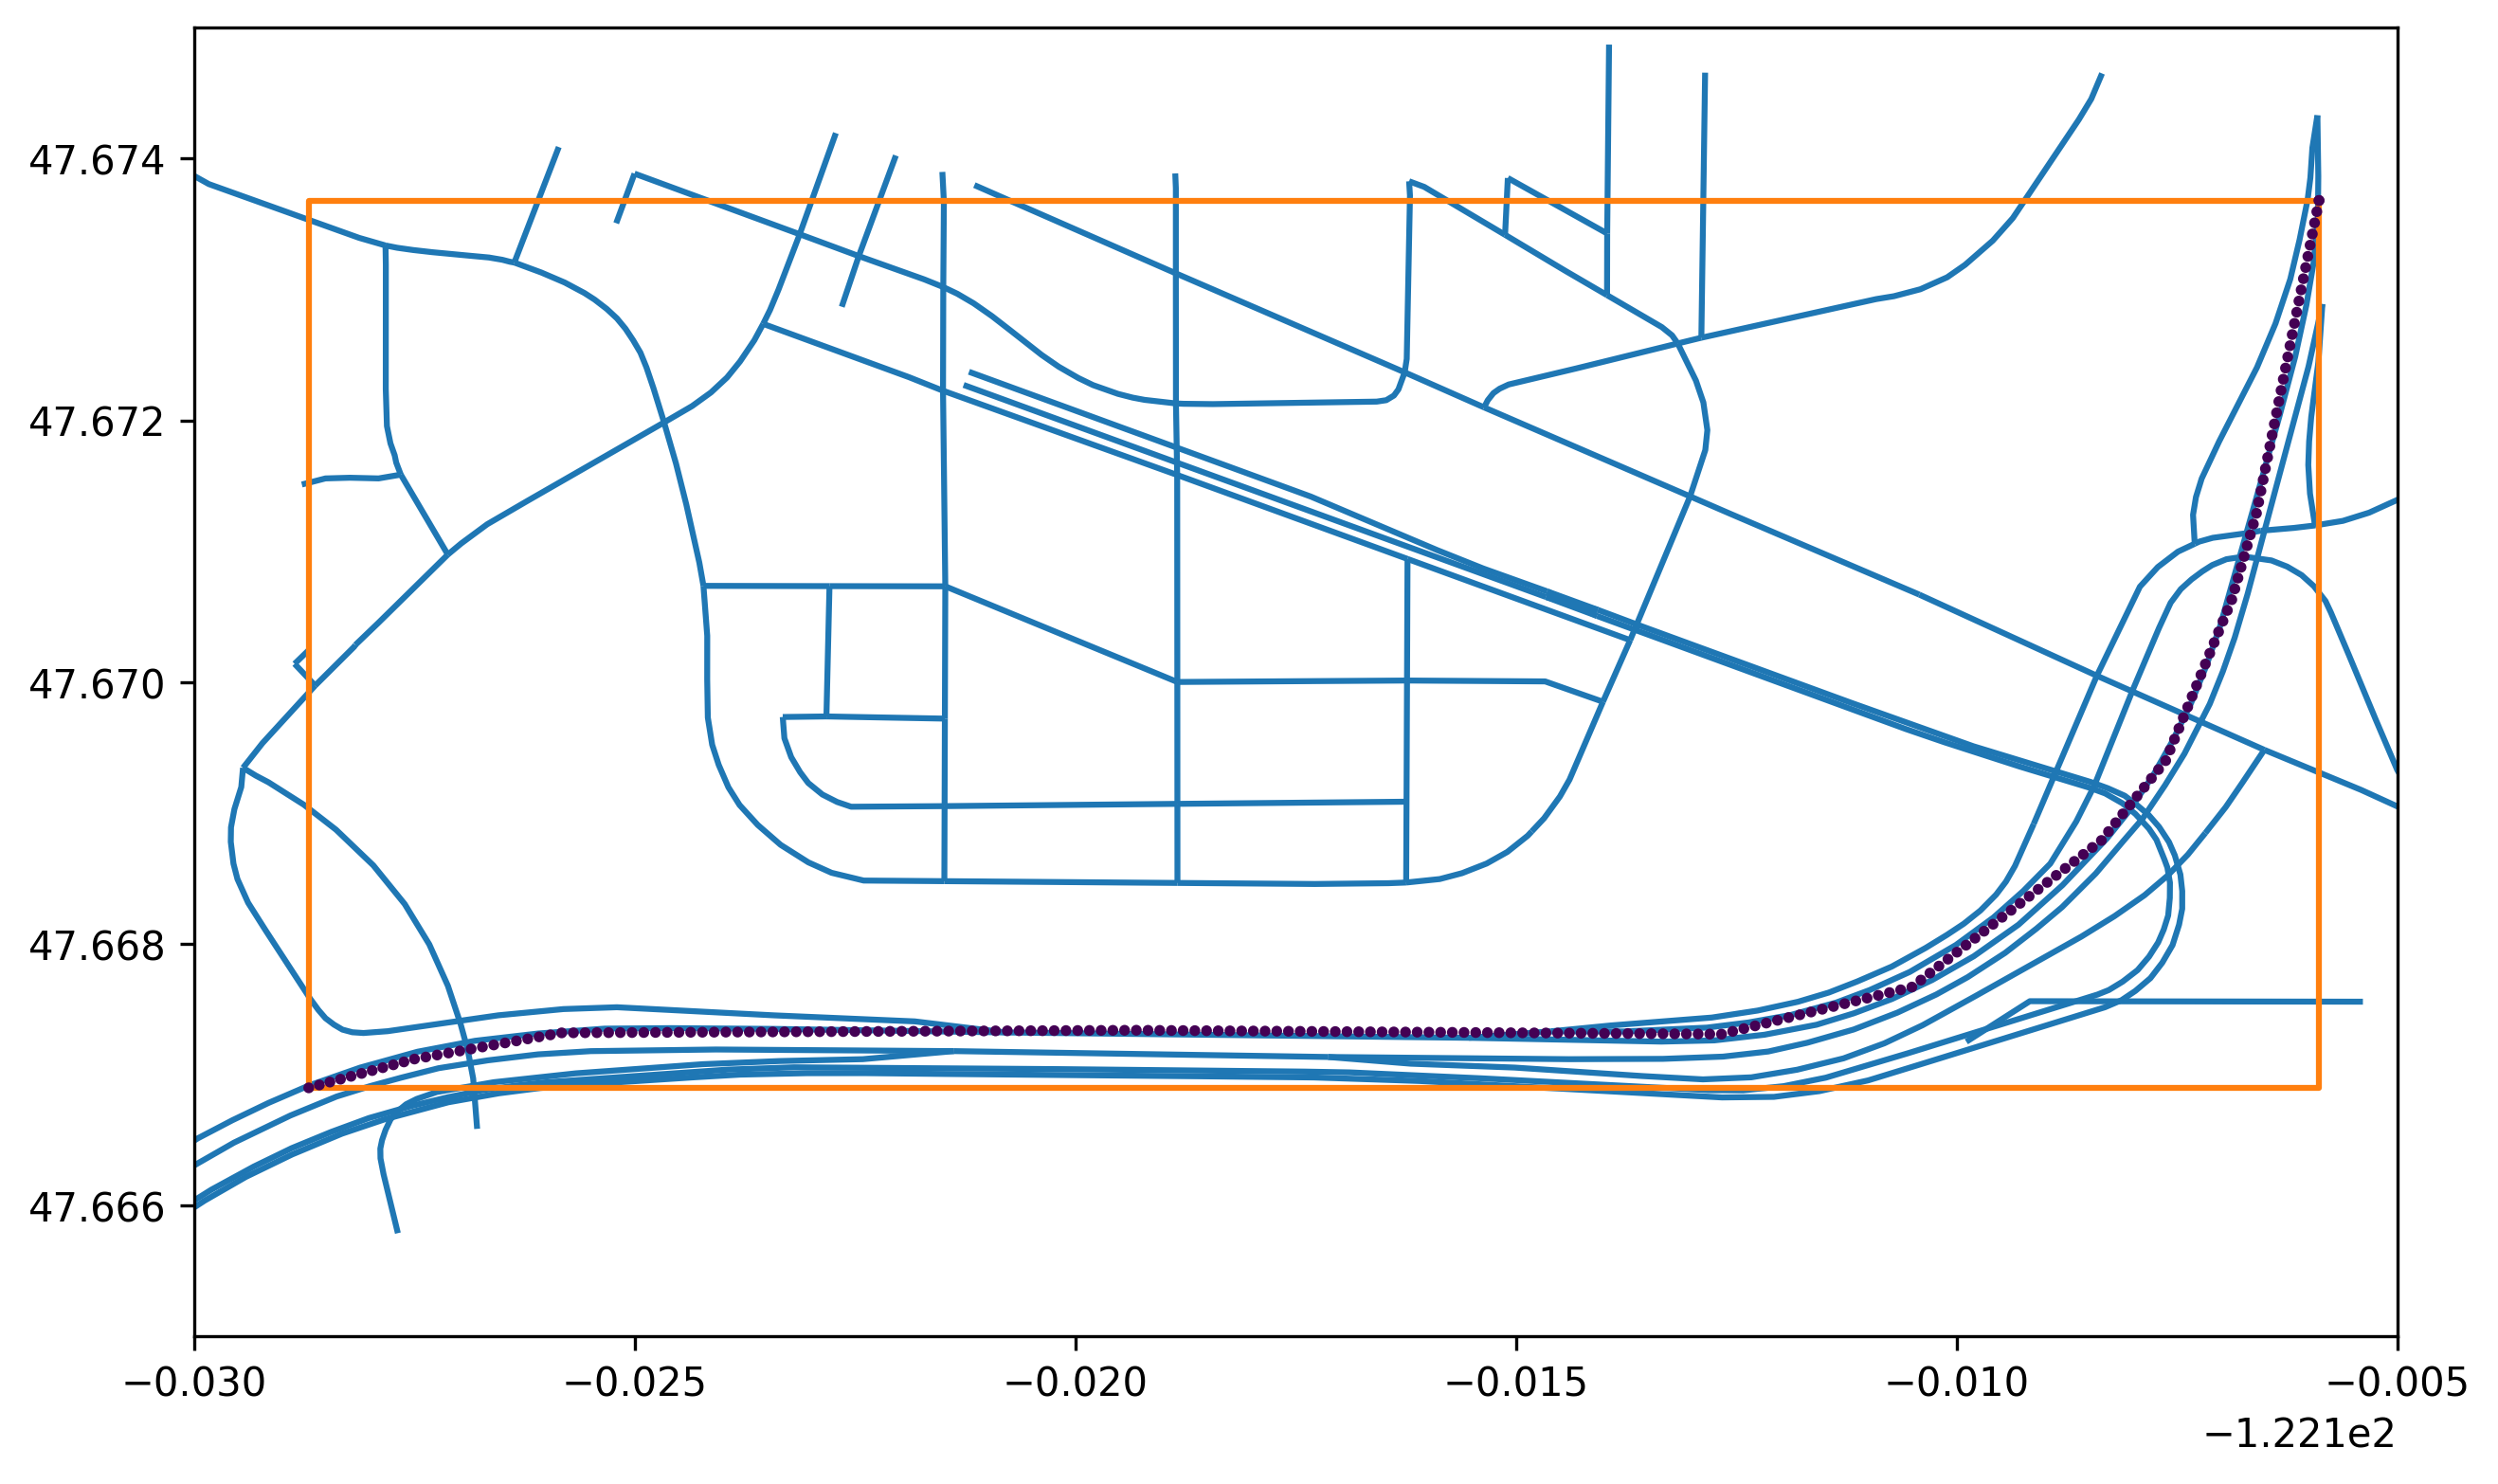

In [38]:
import pyogrio as pio
geometry = gpd.GeoSeries(interpolated_route_geom).apply(lambda x: shapely.ops.transform(flip, x))

# get the bounding box of the route.
shape_bounds = gt.get_bounding_box(shapely.LineString(list(geometry)))

limits = pio.read_dataframe(data_path).to_crs(epsg=4326)

bound_streets = limits[limits.apply(lambda x: shape_bounds.intersects(x.geometry), axis=1).reset_index(drop=True) == True][['geometry', "SPEED_LIM"]]
gs = gpd.GeoSeries(interpolated_route_geom).apply(lambda x: shapely.ops.transform(flip, x))
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
bound_streets.plot(ax=ax, zorder=1)
lim_data.plot("limit",ax=ax, zorder=5, alpha=1,markersize=3)
ax.set_xlim(-122.13, -122.105)
ax.set_ylim(47.665, 47.675)
x,y = gt.get_bounding_box(shapely.LineString(list(geometry))).exterior.xy
ax.plot(x,y, c='tab:orange')

This figure helps depict how the process is done. The street data are limited to the bounding box (in orange) that can encompass all of the points in the route. Then, it iterates through those points to aquire a list of possible speed limits that point could have. If there's an overlap, it takes the one that's highest. If there's no available data, it will use the last known value. 
This whole methodology can be used if you have signal data or stop data, too! In this case, this segment of road has neither - being a highway - so we won't worry about those.

## The Route object
The route object is a class object that is used to store, save, and load information about a given route. In other words, it can contain the geometry, elevation, limits, stops, signals, and signs!

In [39]:
smoothed_dsm_elev

array([31.3718204 , 30.71551209, 30.09551598, 29.50866912, 28.95180855,
       28.42177132, 27.91539446, 27.42951504, 26.96097009, 26.50659665,
       26.06323178, 25.62771252, 25.19687592, 24.74602073, 24.28997842,
       23.82191021, 23.34874407, 22.86726978, 22.37475302, 21.91108231,
       21.42156   , 20.93620865, 20.45554091, 19.98879426, 19.51293033,
       19.0398994 , 18.56266633, 18.0818677 , 17.60090617, 17.11958119,
       16.60355532, 16.43083844, 16.07778381, 15.7349537 , 15.40860542,
       15.09772112, 14.80883074, 14.5279292 , 14.26948643, 14.01022765,
       13.79075048, 13.59051456, 13.38555428, 13.23965968, 13.12033598,
       13.02125992, 12.94277341, 12.87834913, 12.83337083, 12.79782455,
       12.77239624, 12.74972054, 12.73448515, 12.72132001, 12.7112109 ,
       12.75628915, 12.76454365, 12.77316323, 12.76924959, 12.77904308,
       12.78894176, 12.79682345, 12.80034662, 12.80036221, 12.81972163,
       12.82624402, 12.83220779, 12.87126866, 12.88653157, 12.86

In [40]:
example_route = gt.Route(geometry = interpolated_route_geom,
                         elevation=smoothed_dsm_elev/1000,
                         limits=list(lim_data['limit']/2236.93629205),
                         stops=None,
                         signals = None,
                         signs = None)

And now, we can call a variety of different parameters about this route, things like bearing at each point, distance between points, elevation changes, cumulative distance, and grades!
But, what about those parameters we left empty?!<br>
Well: If we leave limits empty, the speed limit will be set at a default 25 mph for each point. If we leave stops, signals, or signs empty, the intersperse flag will intersperse those with a handful of periodic stops. There will be 10 bus stops, 10 signals, and 3 signs.<br><br>
But, given we didn't pass that, they will remain empty. (Empty here meaning populated with -1).

In [41]:
example_route.stops

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,


In [42]:
#If you want to save it, you can use the following:
example_route.save_to_json("./KC_Example_Data/Example_Route_Save/example_redmond.json")

'./KC_Example_Data/Example_Route_Save/example_redmond.json'

In [43]:
#and you can load it again with this: 
loaded_route = gt.load_from_json('./KC_Example_Data/Example_Route_Save/example_redmond.json')

# and show it as a geodataframe like so!
loaded_route.to_gdf()

,geometry,elevation,limit,stop,signal,sign,bearing,grade,dx_to_next,dz_to_next,travel_dx,sum_travel_dx
0,POINT (47.667 -122.129),0.031372,0.024587,-1,-1,-1,N,-7.027934,0.009339,0.000656,0.009362,0.009362
1,POINT (47.667 -122.129),0.030716,0.024587,-1,-1,-1,N,-7.027934,0.009339,0.000620,0.009359,0.018721
2,POINT (47.667 -122.128),0.030096,0.024587,-1,-1,-1,N,-6.639095,0.009339,0.000587,0.009357,0.028078
3,POINT (47.667 -122.128),0.029509,0.024587,-1,-1,-1,N,-6.284126,0.009339,0.000557,0.009355,0.037433
4,POINT (47.667 -122.128),0.028952,0.024587,-1,-1,-1,N,-5.963026,0.009339,0.000530,0.009354,0.046786
...,...,...,...,...,...,...,...,...,...,...,...,...
217,POINT (47.673 -122.106),0.016725,0.024587,-1,-1,-1,NW,-1.174267,0.009679,0.000080,0.009680,2.143922
218,POINT (47.674 -122.106),0.016645,0.024587,-1,-1,-1,NW,-0.824802,0.009679,0.000043,0.009680,2.153602
219,POINT (47.674 -122.106),0.016602,0.024587,-1,-1,-1,NW,-0.447613,0.009679,0.000004,0.009679,2.163281
220,POINT (47.674 -122.106),0.016598,0.024587,-1,-1,-1,N,7.500000,0.000000,-0.000038,0.000038,2.163319


And that's about it for how to use the geography tools!!